 Roberta-Large Named Entity Recognizition on Kaggle NLP Competition with PyTorch


---------------------

### [Kaggle - Feedback Prize - Evaluating Student Writing](https://www.kaggle.com/competitions/feedback-prize-2021)

### You can run the Notebook `Pytorch-Roberta_Large.ipynb`  either Locally or in Kaggle - Just modify the 'ROOT_DIR' variable to properly refer to the dataset

[Feedback Prize-Evaluating Student Writing](https://www.kaggle.com/c/feedback-prize-2021)


-------------------------------------------

## The classification Problem in this competition

Basically, we have a bunch of essays written by kids in the age range of about 12-18 years old in which we have to find word sequences that can be classified as one of 7 "discourse types", which are

* Lead - an introduction that begins with a statistic, a quotation, a description, or some other device to grab the reader’s attention and point toward the thesis
  Interestingly, this is not present in all the the training set data. Around 40% of the ids do not have a lead!

* Position - an opinion or conclusion on the main question
  Almost all the training data has a Position. However, it is not always at the beginning. 

* Claim - a claim that supports the position
  Almost all the training data has a Claim. One training set data has 12 Claims!! Over half have at least 3 claims

* Counterclaim - a claim that refutes another claim or gives an opposing reason to the position

* Rebuttal - a claim that refutes a counterclaim

* Evidence - ideas or examples that support claims, counterclaims, or rebuttals.

* Concluding Statement - a concluding statement that restates the claims

So basically, we are tasked with giving feedback on argumentative essays written by students. Specifically, our task is to predict the human annotations.

This annotation will be done in 2 steps:

### - Segment each essay into discrete, rhetorical and argumentative elements (i.e., discourse elements) .

### - Classify each element as one of 7 "discourse types",

## Basics on the training data

We have a bunch of text files and a separate train.csv with labels. 

In the csv, we get reference to the text files, and then multiple lines per text file with spans indicating a specific discourse type.

The Ground Truth here is a combination of the discourse type and the prediction string. 

Here, Kaggle provides labels as characters (discourse start, discourse end) or words (predictionstring). 

--------------

train.csv - a .csv file containing the annotated version of all essays in the training set


* **discourse_id** - discourse_id is a unique identifier for each discourse element. Basically, each row in train.csv contains one discourse element, and the discourse_id is what identifies each of these discourse elements.

It is different to the 'id' column in that 'id' is the identifier of the full student essay that the discourse element came from. So multiple rows can have the same value for 'id'. On the other hand, each row in train.csv will have a different value for 'discourse_id', since each row is a different discourse element.

Hope that helps and let me know if it's still unclear.

* **discourse_start** - character position where discourse element begins in the essay response

* **discourse_end** - character position where discourse element ends in the essay response

* **discourse_text** - text of discourse element

* **discourse_type** - classification of discourse element

* **discourse_type_num** - enumerated class label of discourse element

* **predictionstring** - the word indices of the training sample, as required for predictions

The **predictionstring** corresponds to - the index of the words in the essay and the predicted discourse type for this sequence of words, SHOULD be correct. 

There can be partial matches, if the correct discourse type is predicted but on a longer or shorter sequence of words than specified in the Ground Truth.

https://www.kaggle.com/code/erikbruin/nlp-on-student-writing-eda

### Notebook keypoints

- Build a baseline model taking this as a token classification or "NER" problem
- Build a "RoBERTa-large" model with `max_length=512`
- A NER "ShortFormer" with chunks, strides
- Manage the chunking with stride of the texts with length greater than 512 (and the posterior merge).


1. At the tokenizing step, where I used the hugging face tokenizer functionality to leverage the chunking
2. Validation is now performed on a per-epoch fashion


## The reason behind the focus on Longformer in this competiton

For the Transformer models, the Transformer architecture - has a matrix multiplication that scales quadratically with the input sequence length in terms of memory, making the regular Transformer very expensive for longer sequences. Because of which we have the `512` tokens max length in the BERT-like models.

As a partial solution to this, we have [LongFormer](https://arxiv.org/abs/2004.05150) and [BigBird](https://arxiv.org/abs/2007.14062)

The Longformer model's attention mechanism is designed to enable efficient processing of long sequences. It differs from standard self-attention mechanisms in a few key ways:

Sliding Window Attention: Instead of attending to all positions in the input sequence as in standard self-attention, the Longformer attends only to a sliding window of adjacent positions. This reduces the computational complexity of the attention mechanism from O(n^2) to O(n), where n is the length of the input sequence.

With LongFormer the lower cost of sparse self-attention mechanisms allows these models to handle up to `4096` in a regular GPU, which is, `8x` what a normal Transformer can.

Given the lengths of the texts in this competition, many focus "Longformer" type models.

However, the classic 512-token models such as BERT do have a mechanism to handle sequence of length greater than `512` basically by

1. Split it into chunks of `512` tokens (with some overlap with the stride param)
2. Use the model to process those chunks
3. Merge back the predictions over the chunks to obtain predictions over the full text

------------------------------------

## Evaluation Metric - Overlap Concept in this competition

### 1. As per the Evaluation page - "If the overlap between the ground truth and prediction is >= 0.5, and the overlap between the prediction and the ground truth >= 0.5, the prediction is a match and considered a true positive. If multiple matches exist, the match with the highest pair of overlaps is taken."

The **"overlap between the ground truth and prediction"** is a measure of how many words in the ground truth match the predicted words. It is calculated as the number of words that appear in both the ground truth and the prediction divided by the total number of words in the ground truth. 

For example, if the ground truth for a sample contains 10 words and the model predicts 8 of those words correctly, the overlap between the ground truth and prediction would be 0.8 or 80%.

On the other hand, the **"overlap between the prediction and the ground truth"** is a measure of how many words in the prediction match the words in the ground truth. It is calculated as the number of words that appear in both the ground truth and the prediction divided by the total number of words in the prediction. 

For example, if the model predicts 12 words for a sample and 10 of those words match the words in the ground truth, the overlap between the prediction and ground truth would be 0.83 or 83%.

Example:
Ground truth: 1 2 3 4 5
Prediction: 1 2 3

Common indices: 1 2 3 (3 common indices)

- overlap between the ground truth and prediction: 3 common indices / 5 ground truth indices = 0.6 (>= 0.5)

- overlap between the prediction and the ground truth: 3 common indices / 3 prediction indices = 1.0 (>= 0.5)

Since both overlaps are greater than or equal to 0.5, this prediction is considered a match (true positive).

### 2. In both, the numerator is the size of the intersection. Both calculations have to be at least 0.5 for the prediction to be considered a hit.

These two measures are used together to determine whether a prediction is a true positive or not. 

By using both measures, the evaluation metric ensures that the predicted words are not only present in the ground truth, but also that the ground truth words are correctly identified by the model.

In some cases, there might be multiple matches (multiple predictions with an overlap >= 0.5). If this happens, the competition rules state that the match with the highest pair of overlaps is considered.

### 3. "If multiple matches exist, the match with the highest pair of overlaps is taken" - 

This statement means that if there are several predictions that match a single ground truth, only the prediction with the highest overlaps (for both ground truth and prediction) will be considered a true positive.

Example:
Ground truth: 1 2 3 4 5
Prediction 1: 1 2 3
Prediction 2: 1 2 3 4

In this example, both predictions match the ground truth. However, Prediction 2 has a higher overlap and will be considered the true positive. Prediction 1 will not be considered.

### 4. "Any unmatched ground truths are false negatives and any unmatched predictions are false positives."


This statement means that any ground truth without a corresponding matching prediction is considered a false negative (missed correct prediction), and any prediction without a corresponding matching ground truth is considered a false positive (incorrect prediction).

Example:
Ground truth: 1 2 3 4 5
Prediction: 1 2

Since the overlaps are not >= 0.5 for both ground truth and prediction, this prediction is considered a false positive. And since there's no match for the ground truth, it's considered a false negative.

A basic implementation of the above concept will like below 

### Below code is just for clarification of the concept, as for implementations for this project, I will use a slightly different version of this code later.

```py

def calculate_overlap(ground_truth, prediction):
    ground_truth_set = set(ground_truth)
    prediction_set = set(prediction)
    
    intersection = ground_truth_set.intersection(prediction_set)
    overlap_ground_truth = len(intersection) / len(ground_truth_set)
    overlap_prediction = len(intersection) / len(prediction_set)
    
    return overlap_ground_truth, overlap_prediction

def evaluate_overlap(ground_truth, prediction):
    overlap_ground_truth, overlap_prediction = calculate_overlap(ground_truth, prediction)
    
    if overlap_ground_truth >= 0.5 and overlap_prediction >= 0.5:
        return "True Positive"
    elif overlap_ground_truth < 0.5:
        return "False Negative"
    elif overlap_prediction < 0.5:
        return "False Positive"

# Example usage
ground_truth = [1, 2, 3, 4, 5]
prediction = [1, 2, 3]

result = evaluate_overlap(ground_truth, prediction)
print(result)  # Output: True Positive


```

# Imports

In [1]:
import os
import gc
import ast
import time
import wandb
from tqdm import tqdm
from collections import defaultdict

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

import torch
from torch.utils.data import Dataset, DataLoader

from transformers import AutoConfig, AutoTokenizer, AutoModelForTokenClassification

from train import *
from utils import *
from const import *
from validation import *

import warnings
warnings.filterwarnings("ignore")

os.environ['TOKENIZERS_PARALLELISM'] = 'false'


In [2]:
torch.cuda.is_available()

True

## WANDB

In [3]:
initialize_wandb(project='ner', run_name=RUN_NAME, config=config)

In [ ]:
# df_train_org = pd.read_csv('../input/feedback-prize-2021/train.csv')
df_train_org = pd.read_csv(ROOT_DIR + 'train.csv')
print(df_train_org.shape)
display(df_train_org.head())

## Create new Column for plotting Length and frequency and relative position per discourse_type

In [5]:
df_train_org_copy = df_train_org.copy()


In [6]:
df_train_org_copy.head()

id  discourse_id  discourse_start  discourse_end  \
0  423A1CA112E2  1.622630e+12                8            229   
1  423A1CA112E2  1.622630e+12              230            312   
2  423A1CA112E2  1.622630e+12              313            401   
3  423A1CA112E2  1.622630e+12              402            758   
4  423A1CA112E2  1.622630e+12              759            886   

                                      discourse_text discourse_type  \
0  Modern humans today are always on their phone....           Lead   
1  They are some really bad consequences when stu...       Position   
2  Some certain areas in the United States ban ph...       Evidence   
3  When people have phones, they know about certa...       Evidence   
4  Driving is one of the way how to get around. P...          Claim   

  discourse_type_num                                   predictionstring  
0             Lead 1  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...  
1         Position 1       45 46 47 48 49 50 51 52 53 54 55 56 57 58 59  
2         Evidence 1    60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75  
3         Evidence 2  76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...  
4            Claim 1  139 140 141 142 143 144 145 146 147 148 149 15...

In [7]:
df_train_org_copy["discourse_len"] = df_train_org_copy["discourse_text"].apply(lambda x: len(x.split()))
df_train_org_copy["pred_len"] = df_train_org_copy["predictionstring"].apply(lambda x: len(x.split()))

cols_to_display = ['discourse_id', 'discourse_text', 'discourse_type','predictionstring', 'discourse_len', 'pred_len']

df_train_org_copy[cols_to_display].head()

discourse_id                                     discourse_text  \
0  1.622630e+12  Modern humans today are always on their phone....   
1  1.622630e+12  They are some really bad consequences when stu...   
2  1.622630e+12  Some certain areas in the United States ban ph...   
3  1.622630e+12  When people have phones, they know about certa...   
4  1.622630e+12  Driving is one of the way how to get around. P...   

  discourse_type                                   predictionstring  \
0           Lead  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...   
1       Position       45 46 47 48 49 50 51 52 53 54 55 56 57 58 59   
2       Evidence    60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75   
3       Evidence  76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...   
4          Claim  139 140 141 142 143 144 145 146 147 148 149 15...   

   discourse_len  pred_len  
0             44        44  
1             15        15  
2             16        16  
3             63        63  
4             24        24

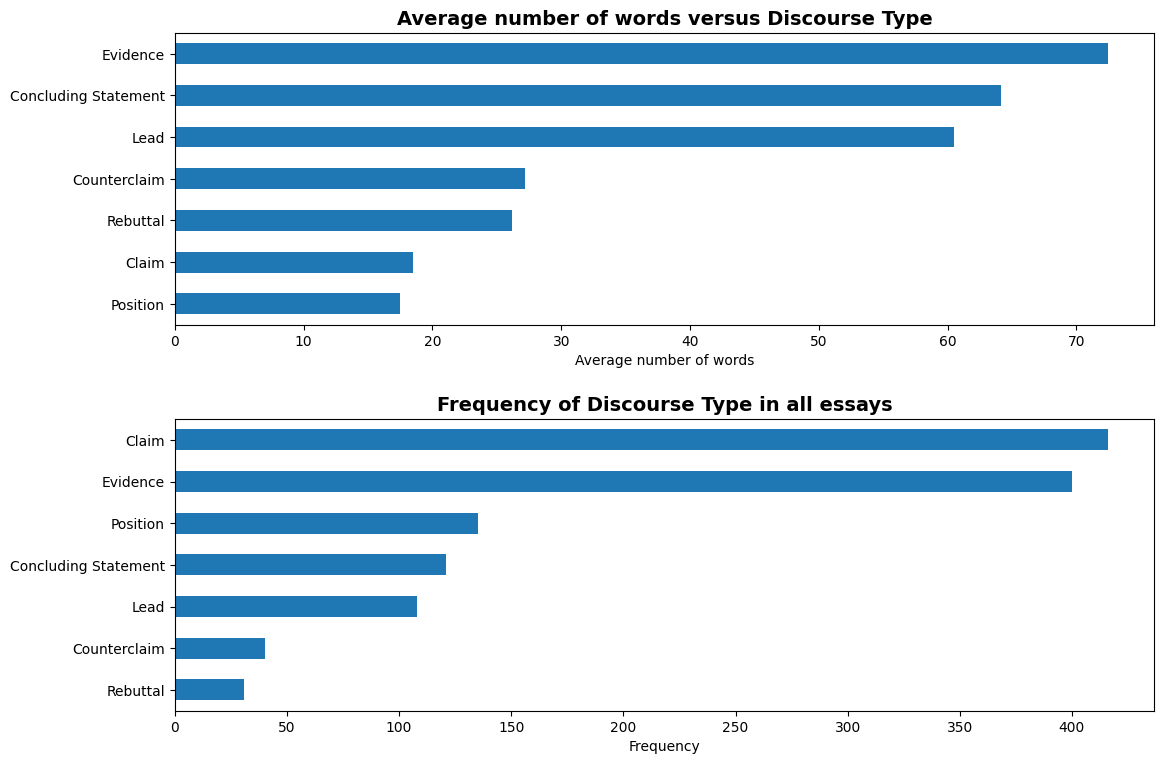

In [8]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(211)
ax1 = df_train_org_copy.groupby('discourse_type')['discourse_len'].mean().sort_values().plot(kind="barh")
ax1.set_title("Average number of words versus Discourse Type", fontsize=14, fontweight = 'bold')
ax1.set_xlabel("Average number of words", fontsize = 10)
ax1.set_ylabel("")

ax2 = fig.add_subplot(212)
ax2 = df_train_org_copy.groupby('discourse_type')['discourse_type'].count().sort_values().plot(kind="barh")
ax2.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ','))) #add thousands separator
ax2.set_title("Frequency of Discourse Type in all essays", fontsize=14, fontweight = 'bold')
ax2.set_xlabel("Frequency", fontsize = 10)
ax2.set_ylabel("")

plt.tight_layout(pad=2)
plt.show()

Looking at the above graph, is there a correlation between the length of a discourse and the class (discourse_type)? Yes, there is. Evidence is the longest discourse type on average. 

When looking at the frequencies of occurence, we see that Counterclaim and Rebuttal are relatively rare

-----------------------

## Convert Train Text to NER Labels
We will now convert all text words into NER labels and save in a dataframe.

In [9]:
input_dir = ROOT_DIR + 'train/'
output_file = 'train_NER.csv'

df_ner_texts = attach_ner_to_text(input_dir, output_file, df_train_org)
df_ner_texts.head()

100%|██████████| 136/136 [00:00<00:00, 2014.39it/s]


id                                               text  \
0  006FCE4404E3  Phones and driving\n\nHave you ever seen someo...   
1  019328A0D7A3  Phones and Driving\n\nLook around you! All you...   
2  0300455258CB  There is a lot of young teenagers and also adu...   
3  0421128DEE6C  Phones & Driving\n\nBefore cell phones were in...   
4  077DD935321C  Phones and Driving\n\nOver the last few years ...   

                                          text_split  \
0  [Phones, and, driving, Have, you, ever, seen, ...   
1  [Phones, and, Driving, Look, around, you!, All...   
2  [There, is, a, lot, of, young, teenagers, and,...   
3  [Phones, &, Driving, Before, cell, phones, wer...   
4  [Phones, and, Driving, Over, the, last, few, y...   

                                            entities  
0  [O, O, O, B-Lead, I-Lead, I-Lead, I-Lead, I-Le...  
1  [O, O, O, B-Lead, I-Lead, I-Lead, I-Lead, I-Le...  
2  [B-Position, I-Position, I-Position, I-Positio...  
3  [O, O, O, B-Lead, I-Lead, I-Lead, I-Lead, I-Le...  
4  [O, O, O, B-Lead, I-Lead, I-Lead, I-Lead, I-Le...

In [10]:
# Check that we have created one entity/label for each word correctly
assert (df_ner_texts['text_split'].str.len() == df_ner_texts['entities'].str.len()).all(), "Lengths of text_split and entities do not match for all rows."

# df_ner_texts['text_split'].str.len(): computes the length (number of words) for each list in the 'text_split' column. The .str accessor is used to perform vectorized string operations, and the .len() method computes the length of each list.
# The .all() method checks if all the elements in the resulting boolean Series are True.

## Train and Validation splits

In [ ]:
IDS_ALL_UNIQUE = df_train_org.id.unique()
print(f'There are {len(IDS_ALL_UNIQUE)} train texts. We will split 90% 10% for validation.')

# train valid split 90% 10%

# Set the random seed for NumPy to ensure that the random sampling will produce the same results each time the code is run. This is useful for reproducibility.
np.random.seed(42)

train_idx = np.random.choice(np.arange(len(IDS_ALL_UNIQUE)),int(0.9*len(IDS_ALL_UNIQUE)),replace=False)
#  np.arange() function generates an array of evenly spaced values. In this case, it creates an array of integers starting from 0 up to (but not including) len(IDS_ALL_UNIQUE). This array represents the indices of the unique IDs.
# np.random.choice generates a random sample from a given 1-D array or range of integers. It can be used to select random elements from an array or to create random samples without replacement. The 2-nd param to np.random.choice() is the output size. replace=False, means each element can only be selected once. 


valid_idx = np.setdiff1d(np.arange(len(IDS_ALL_UNIQUE)),train_idx)
# np.setdiff1d() function is used to find the difference between two arrays. In this case, it computes the difference between the array of all indices (np.arange(len(IDS))) and the selected training indices (train_idx). The result is an array containing the indices not present in the training set, which will be used for the validation set.
np.random.seed(None)

# CREATE TRAIN SUBSET AND VALID SUBSET
df_train = df_ner_texts.loc[df_ner_texts['id'].isin(IDS_ALL_UNIQUE[train_idx])].reset_index(drop=True)

df_val = df_ner_texts.loc[df_ner_texts['id'].isin(IDS_ALL_UNIQUE[valid_idx])].reset_index(drop=True)

""" The `reset_index(drop=True)` call is used to reset the index of the DataFrame after filtering out some columns. By default, when columns are filtered from a DataFrame, the index remains the same, and the original index values are preserved. However, in some cases, such as when joining or merging DataFrames, it can be helpful to have a simple sequential index with no missing values.

By setting `drop=True`, the old index is dropped and a new sequential index is created. The `copy()` method is used to create a copy of the DataFrame with the new index, instead of modifying the original DataFrame in place. """

print(f"FULL Dataset : {df_ner_texts.shape}")
print(f"TRAIN Dataset: {df_train.shape}")
print(f"TEST Dataset : {df_val.shape}")

## Download model from huggingface  hub

In [13]:
download_hf_model(MODEL_PATH, MODEL_NAME )

In [14]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

In [ ]:
%%time
tokenized_train = tokenize(df_train, tokenizer, DOC_STRIDE, MAX_LEN, LABELS_TO_IDS)
tokenized_val = tokenize(df_val, tokenizer, DOC_STRIDE, MAX_LEN, LABELS_TO_IDS)

In [ ]:
len(tokenized_train['input_ids'])

In [18]:
tokenized_train['overflow_to_sample_mapping'][:10]

tensor([0, 0, 1, 2, 3, 4, 5, 6, 7, 7])

In [19]:
tokenized_train

{'input_ids': tensor([[    0,  4129,  6909,  ...,     4, 31118,     2],
         [    0,  4247,   197,  ...,     1,     1,     1],
         [    0,   345,    16,  ...,     1,     1,     1],
         ...,
         [    0,    96,   452,  ...,     1,     1,     1],
         [    0,  7698,    47,  ...,    66,     6,     2],
         [    0,   370,  1394,  ...,     1,     1,     1]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'overflow_to_sample_mapping': tensor([  0,   0,   1,   2,   3,   4,   5,   6,   7,   7,   8,   8,   9,  10,
          11,  11,  12,  12,  13,  14,  15,  16,  17,  18,  18,  19,  19,  20,
          21,  21,  22,  22,  23,  24,  25,  25,  26,  26,  27,  28,  29,  30,
          30,  31,  32,  33,  34,  35,  35,  36,  36,  37,  37,  38,  39,  39,
          40,  40,  41,  42

## Dataset class

In [21]:
class DataLoaderClass(Dataset):
    """
    Custom PyTorch dataset class for tokenized data.

    Args:
        tokenized_ds (dict): Tokenized dataset.

    """
    def __init__(self, tokenized_ds):
        self.data = tokenized_ds

    def __getitem__(self, index):
        """
        Retrieves an item from the dataset at the specified index.

        Args:
            index (int): Index of the item to retrieve.

        Returns:
            dict: Dictionary containing the item data.

        """
        # print('print data ', self.data)
        item = {k: self.data[k][index] for k in self.data.keys()}
        return item

    def __len__(self):
        """
        Returns the total number of items in the dataset.

        Returns:
            int: Total number of items in the dataset.

        """
        return len(self.data['input_ids'])
    

# Create Datasets and DataLoaders for training and validation dat

ds_train = DataLoaderClass(tokenized_train)

ds_val = DataLoaderClass(tokenized_val)

dataloader_train = DataLoader(ds_train, batch_size=config['train_batch_size'], 
                      shuffle=True, num_workers=0, pin_memory=True)

dataloader_val = DataLoader(ds_val, batch_size=config['valid_batch_size'], 
                    shuffle=False, num_workers=0, pin_memory=True)

## OUTPUT OF `print('print data ', self.data)` in `__getitem__(self, index)` method above

```
{'input_ids': tensor([[    0,  4129,  6909,  ...,     4, 31118,     2],
        [    0,  4247,   197,  ...,     1,     1,     1],
        [    0,   345,    16,  ...,     1,     1,     1],
        ...,
        [    0,    96,   452,  ...,     1,     1,     1],
        [    0,  7698,    47,  ...,    66,     6,     2],
        [    0,   370,  1394,  ...,     1,     1,     1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'overflow_to_sample_mapping': tensor([  0,   0,   1,   2,   3,   4,   5,   6,   7,   7,   8,   8,   9,  10,
         11,  11,  12,  12,  13,  14,  15,  16,  17,  18,  18,  19,  19,  20,
         21,  21,  22,  22,  23,  24,  25,  25,  26,  26,  27,  28,  29,  30,
         30,  31,  32,  33,  34,  35,  35,  36,  36,  37,  37,  38,  39,  39,
         40,  40,  41,  42,  42,  43,  44,  44,  45,  46,  47,  48,  49,  50,
         51,  51,  52,  53,  54,  54,  55,  55,  56,  56,  57,  58,  58,  59,
         60,  61,  61,  62,  62,  62,  63,  64,  65,  66,  67,  68,  69,  70,
         70,  71,  72,  73,  74,  75,  75,  76,  77,  77,  78,  78,  79,  80,
         81,  82,  83,  83,  84,  85,  86,  87,  87,  88,  89,  90,  91,  92,
         93,  93,  93,  94,  95,  95,  96,  96,  97,  98,  98,  99,  99, 100,
        101, 101, 102, 103, 104, 104, 105, 105, 106, 107, 107, 108, 109, 109,
        110, 110, 111, 112, 112, 113, 113, 114, 114, 115, 116, 117, 117, 118,
        119, 120, 121, 121]), 'labels': tensor([[-100,    0,    0,  ...,    0,    0, -100],
        [-100,   14,   14,  ..., -100, -100, -100],
        [-100,    3,    4,  ..., -100, -100, -100],
        ...,
        [-100,    1,    2,  ..., -100, -100, -100],
        [-100,    1,    2,  ...,    0,    0, -100],
        [-100,    0,    0,  ..., -100, -100, -100]]), 'wids': tensor([[ -1,   0,   0,  ..., 457, 458,  -1],
        [ -1, 354, 355,  ...,  -1,  -1,  -1],
        [ -1,   0,   1,  ...,  -1,  -1,  -1],
        ...,
        [ -1,   0,   1,  ...,  -1,  -1,  -1],
        [ -1,   0,   1,  ..., 435, 435,  -1],
        [ -1, 328, 329,  ...,  -1,  -1,  -1]])}
```

In [22]:
IDS_TO_LABELS

{0: 'O',
 1: 'B-Lead',
 2: 'I-Lead',
 3: 'B-Position',
 4: 'I-Position',
 5: 'B-Claim',
 6: 'I-Claim',
 7: 'B-Counterclaim',
 8: 'I-Counterclaim',
 9: 'B-Rebuttal',
 10: 'I-Rebuttal',
 11: 'B-Evidence',
 12: 'I-Evidence',
 13: 'B-Concluding Statement',
 14: 'I-Concluding Statement'}

# Model Definition

In [23]:
config_model = AutoConfig.from_pretrained(MODEL_PATH+'/config.json') 
model = AutoModelForTokenClassification.from_pretrained(
                   MODEL_PATH+'/pytorch_model.bin',config=config_model)
model.to(config['device']);

## Training and validation loop

In [24]:
unique_valid_id_list = IDS_ALL_UNIQUE[valid_idx] # this variable needs to be passed as an argument to the validate() emthod

# Below line is just for checking out that df_valid looks ok, as it will be used 
# inside the validate() method
df_valid = df_train_org.loc[df_train_org['id'].isin(unique_valid_id_list)]

In [25]:
df_valid.head()

id  discourse_id  discourse_start  discourse_end  \
115  019328A0D7A3  1.622470e+12               20            370   
116  019328A0D7A3  1.622470e+12              371            476   
117  019328A0D7A3  1.622470e+12              477           1321   
118  019328A0D7A3  1.622470e+12             1322           1435   
119  019328A0D7A3  1.622470e+12             1436           1498   

                                        discourse_text discourse_type  \
115  Look around you! All you see is people from al...           Lead   
116  Phones can be such a distraction to everyone a...          Claim   
117  A major cause of deaths in the US is motor veh...       Evidence   
118  Many people may say that teens are the ones dr...   Counterclaim   
119  In reality, everyone from every age is irrespo...       Rebuttal   

    discourse_type_num                                   predictionstring  
115             Lead 1  3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20...  
116            Claim 1  65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 8...  
117         Evidence 1  83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 9...  
118     Counterclaim 1  229 230 231 232 233 234 235 236 237 238 239 24...  
119         Rebuttal 1                248 249 250 251 252 253 254 255 256

In [26]:
# Here just testing the get_prediction() method
out_of_fold = get_predictions(df_val, dataloader_val, model)
out_of_fold.head()

id     class predictionstring
0  019328A0D7A3  Rebuttal                0
1  019328A0D7A3     Claim                1
2  019328A0D7A3      Lead                2
3  019328A0D7A3      Lead                3
4  019328A0D7A3     Claim                4

In [ ]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=config['learning_rates'][0])

for epoch in range(config['epochs']):
    print()
    train(model, optimizer, dataloader_train, epoch)
    validate(model, df_train_org, df_val, dataloader_val, epoch, IDS_ALL_UNIQUE)
    
print("Final model 'pytorch_model.bin'")

torch.save(model.state_dict(), 'pytorch_model.bin')